In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

## Connect to the database and create dataframes for each table

In [4]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


## Merge and clean the cities, states and countries tables

In [5]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [6]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [7]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,2,Kurt,Cobain,27,suicide,rock,110979
2,17,Chris,Cornell,52,suicide,rock,126104
3,18,Chester,Bennington,41,suicide,rock,124148
4,32,Ian,Curtis,23,suicide,rock,51499
...,...,...,...,...,...,...,...
347,37,Johnny,Cash,71,diabetes,country,114248
348,148,A.,Carter,68,unknown,country,126050
349,241,Baby,Huey,26,drug overdose,funk,125084
350,307,Robbie,McIntosh,24,drug overdose,funk,49346


In [8]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [9]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [10]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,188,Brian,Epstein,32,drug overdose,rock,Liverpool,England,United Kingdom
3,2,Kurt,Cobain,27,suicide,rock,Aberdeen,Washington,United States
4,17,Chris,Cornell,52,suicide,rock,Seattle,Washington,United States
...,...,...,...,...,...,...,...,...,...
346,301,Don,Rich,32,car/motorcycle accident,country,Olympia,Washington,United States
347,37,Johnny,Cash,71,diabetes,country,Cleveland County,Arkansas,United States
348,241,Baby,Huey,26,drug overdose,funk,Richmond,Indiana,United States
349,307,Robbie,McIntosh,24,drug overdose,funk,Dundee,Scotland,United Kingdom


## Create plots to observe the data

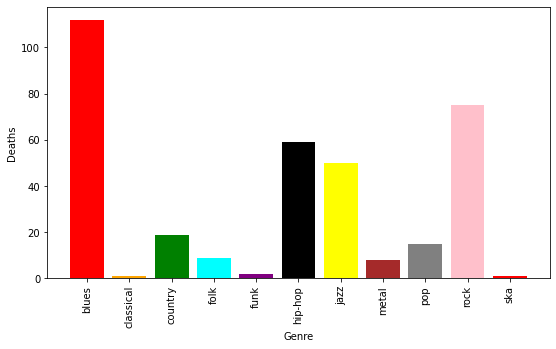

In [11]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5))
plt.bar(df_n.index, df_n, color=
        ['red', 'orange', 'green',
         'cyan', 'purple', 'black',
         'yellow', 'brown', 'grey', 'pink'])
plt.ylabel("Deaths")
plt.xlabel("Genre")
plt.xticks(rotation='vertical')
plt.show()

## Cause of death per music genre

In [12]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause                              genre  
AIDS                               pop        1
                                   rock       1
Burned                             blues      1
Falling                            rock       1
accidental self-inflicted gunshot  blues      1
                                             ..
unknown                            country    1
                                   folk       1
                                   jazz       8
                                   pop        1
                                   rock       1
Length: 82, dtype: int64

# Questions

## Most common Death Ages


In [13]:
n_da = musician['death_age'].value_counts().nlargest(15)

In [14]:
n_da

27    24
32    16
28    13
37    12
25    12
24    11
34    11
30     9
21     9
39     9
26     8
36     8
33     7
46     7
40     7
Name: death_age, dtype: int64

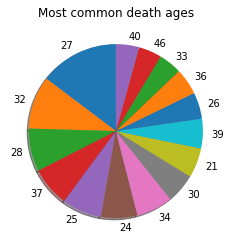

In [15]:

plt.pie(n_da.values, labels=n_da.index, startangle=90, shadow=True)
plt.title("Most common death ages")
# plt.legend(title='Death age', loc=(1, 0.25))
plt.show()

In [16]:
n_da.values

array([24, 16, 13, 12, 12, 11, 11,  9,  9,  9,  8,  8,  7,  7,  7],
      dtype=int64)

## Most common Music Genre

In [17]:
n_mg = musician['genre'].value_counts()

In [18]:
n_mg

blues        112
rock          75
hip-hop       59
jazz          50
country       19
pop           15
folk           9
metal          8
funk           2
ska            1
classical      1
Name: genre, dtype: int64

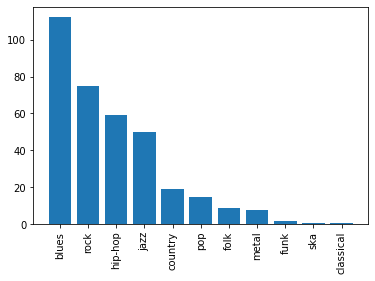

In [19]:
plt.bar(n_mg.index, n_mg.values)
plt.xticks(rotation='vertical')
plt.show()

# Places

### Most common Countries

In [20]:
n_places = musician['Country'].value_counts().nlargest(10)

In [21]:
n_places

United States     290
United Kingdom     31
Germany             4
Jamaica             2
Australia           2
Lithuania           2
Canada              2
New Zealand         2
Tanzania            1
Turkey              1
Name: Country, dtype: int64

### Most common States

In [22]:
n_states = musician['State'].value_counts().nlargest(10)

In [23]:
n_states

Mississippi     32
New York        31
Texas           26
England         24
California      20
Tennessee       20
Louisiana       18
Georgia         14
Alabama         13
Pennsylvania    11
Name: State, dtype: int64

### Most common Cities

In [24]:
n_cities = musician['City'].value_counts().nlargest(10)

In [25]:
n_cities

New York City    18
London           10
Memphis           9
New Orleans       9
Chicago           8
Philadelphia      8
Los Angeles       8
Birmingham        7
Detroit           4
Queens            4
Name: City, dtype: int64

## Death genre - cause

In [26]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [27]:
n_cd_gr

genre    cause                  
hip-hop  homicide                   58
blues    heart disease              34
         cancer                     16
rock     drug overdose              14
jazz     heart disease              13
                                    ..
         tuberculosis                1
metal    aircraft accident           1
         car/motorcycle accident     1
pop      AIDS                        1
ska      suicide                     1
Length: 82, dtype: int64

In [28]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [29]:
n_cd_gr

,genre,cause,deaths
0,hip-hop,homicide,58
1,blues,heart disease,34
2,blues,cancer,16
3,rock,drug overdose,14
4,jazz,heart disease,13
...,...,...,...
77,jazz,tuberculosis,1
78,metal,aircraft accident,1
79,metal,car/motorcycle accident,1
80,pop,AIDS,1


### Blues 

In [30]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [31]:
n_blues

,genre,cause,deaths
1,blues,heart disease,34
2,blues,cancer,16
6,blues,unknown,10
9,blues,homicide,9
12,blues,pneumonia,7
15,blues,car/motorcycle accident,6
16,blues,diabetes,6
20,blues,aircraft accident,4
22,blues,brain related,4
27,blues,alcohol related,3


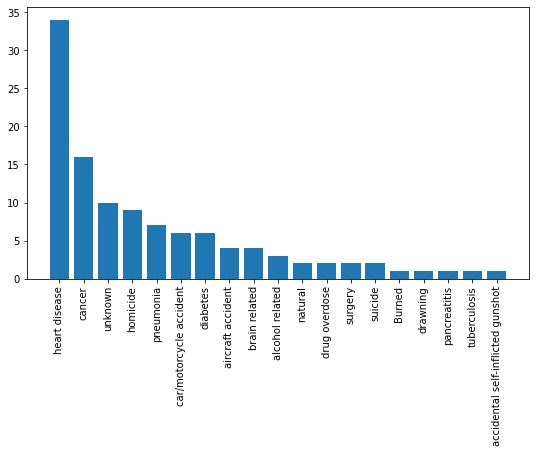

In [32]:
plt.figure(figsize=(9,5))
plt.bar(n_blues['cause'], n_blues['deaths'])
plt.xticks(rotation='vertical')
plt.show()


### Rock

In [33]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [34]:
n_rock

,genre,cause,deaths
3,rock,drug overdose,14
5,rock,suicide,12
7,rock,alcohol related,10
8,rock,heart disease,9
10,rock,car/motorcycle accident,9
19,rock,cancer,4
21,rock,drawning,4
24,rock,aircraft accident,3
38,rock,brain related,2
43,rock,electrocution,2


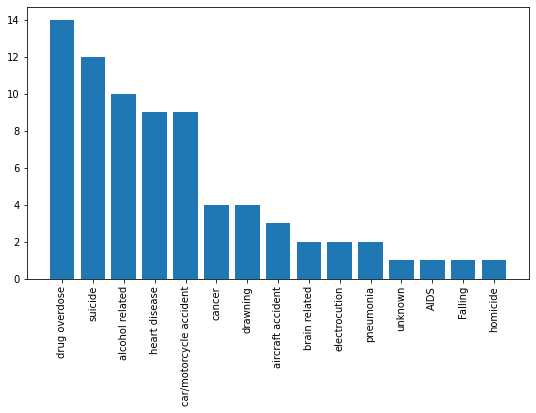

In [35]:
plt.figure(figsize=(9,5))
plt.bar(n_rock['cause'], n_rock['deaths'])
plt.xticks(rotation='vertical')

plt.show()

### Rock vs Blues

In [36]:
n_cause = n_cd_gr['cause'].unique()
n_blues_deaths = n_blues['deaths']
n_rock_deaths = n_rock['deaths']
x_axis = np.arange(len(n_cause))

In [37]:
sort_cause = CategoricalDtype(n_cause, ordered=True)

In [38]:
n_blues.loc[:, 'cause'] = n_blues.loc[:, 'cause'].astype(sort_cause)
n_rock.loc[:, 'cause'] = n_rock.loc[:, 'cause'].astype(sort_cause)

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [39]:
n_blues.sort_values(by='cause', inplace=True)
n_rock.sort_values(by='cause', inplace=True)

<ipython-input-39-bef2d9e6ab9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_blues.sort_values(by='cause', inplace=True)
<ipython-input-39-bef2d9e6ab9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_rock.sort_values(by='cause', inplace=True)


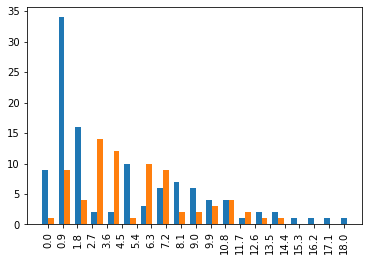

In [81]:
x1 = np.arange(len(n_blues['deaths']))
x2 = np.arange(len(n_rock['deaths']))

offset_x1 = np.zeros(len(n_blues['deaths']))
offset_x2 = np.zeros(len(n_rock['deaths']))

shorter = min(len(x1), len(x2))
width = 0.35

offset_x1[:shorter] = width/2
offset_x2[:shorter] = width/2

fig, ax = plt.subplots()

rects1 = ax.bar(x1 - offset_x1, n_blues['deaths'], width, label='Blues')
rects2 = ax.bar(x2 + offset_x2, n_rock['deaths'], width, label='Rock')


plt.xticks(rotation='vertical')
ax.set_xticks([0, 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9,
              9.9, 10.8, 11.7, 12.6, 13.5, 14.4, 15.3, 16.2, 17.1, 18])





## Most common Cause o deaths

In [41]:
n_cause_death = musician['cause'].value_counts()

In [42]:
n_cause_death

homicide                             73
heart disease                        65
cancer                               30
drug overdose                        29
car/motorcycle accident              25
unknown                              22
suicide                              19
aircraft accident                    17
alcohol related                      15
brain related                        13
pneumonia                            12
diabetes                              8
drawning                              6
surgery                               3
natural                               2
electrocution                         2
AIDS                                  2
tuberculosis                          2
accidental self-inflicted gunshot     2
Falling                               1
Burned                                1
pancreatitis                          1
kidney related                        1
Name: cause, dtype: int64

# Correlation

### Genre - Cause of death

### Age - Cause of death

### Genre - Age